# Análisis de videojuegos con datos de RAWG: Evolución de géneros y puntuaciones

Este notebook combina el análisis de dos dimensiones clave en la industria de los videojuegos:

1. La **evolución del número medio de géneros por juego** a lo largo de los años.
2. La **puntuación media por género principal y año** visualizada mediante un heatmap.

Se parte de un archivo `JSON` con datos descargados desde la API de RAWG y se realiza una limpieza cuidadosa de los datos antes de proceder a la visualización.

###  1. Cargar librerías
Se importan `pandas` para análisis de datos y `plotly.express` para visualizaciones interactivas (burbujas y heatmap).

In [57]:
import pandas as pd
import plotly.express as px

###  2. Cargar datos
Se carga un archivo JSON desde servidor local. 

In [60]:
df = pd.read_json('../../data/raw/juegos_rawg.json')


### 3. Filtrado de datos
Se eliminan juegos que no tienen fecha, puntuación o géneros válidos. También se eliminan juegos con `rating` igual a 0 o muy pocos votos (si `ratings_count` está disponible).

In [87]:
# 1. Filtrado seguro de juegos válidos
df = df[
    df['released'].notna() &  # Tiene fecha
    df['rating'].notna() &    # Tiene puntuación
    df['genres'].apply(lambda g: isinstance(g, list) and len(g) > 0)  # Al menos un género
]

# 2. Eliminar juegos sin puntuación real
df = df[df['rating'] > 0]

# 3. Filtrar por número mínimo de valoraciones (si existe ratings_count)
if 'ratings_count' in df.columns:
    df = df[df['ratings_count'] >= 10]

# 4. Crear una nueva tabla con solo las columnas relevantes
df_filtrado = df[['name', 'released', 'rating', 'genres']].copy()

In [93]:
df_filtrado.head()

,name,released,rating,genres
0,The Witcher 3: Wild Hunt,2015-05-18,4.65,"[{'id': 4, 'name': 'Action', 'slug': 'action'}..."
1,Life is Strange,2015-01-29,4.12,"[{'id': 3, 'name': 'Adventure', 'slug': 'adven..."
2,Fallout 4,2015-11-09,3.81,"[{'id': 4, 'name': 'Action', 'slug': 'action'}..."
3,Rocket League,2015-07-07,3.93,"[{'id': 1, 'name': 'Racing', 'slug': 'racing'}..."
4,Rise of the Tomb Raider,2015-11-10,4.04,"[{'id': 4, 'name': 'Action', 'slug': 'action'}]"


###  4. Limpieza y filtrado por fechas ###
Se convierte la fecha a tipo `datetime` y se filtran los juegos publicados entre 2015 y 2024.

In [96]:
df['fecha_lanzamiento'] = pd.to_datetime(df['released'], errors='coerce')
df = df[
    df['fecha_lanzamiento'].notna() &
    (df['fecha_lanzamiento'].dt.year >= 2015) &
    (df['fecha_lanzamiento'].dt.year <= 2024)
]

###  5. Variables derivadas
Se crean dos nuevas columnas: `año` (año de lanzamiento) y `n_generos` (cantidad de géneros por juego).

In [99]:
df['año'] = df['fecha_lanzamiento'].dt.year
df['n_generos'] = df['genres'].apply(lambda g: len(g) if isinstance(g, list) else 0)

### 6. Cálculo del número medio de géneros
Se agrupa por año y se calcula el número medio de géneros por juego. El valor se redondea a dos decimales. 

In [102]:
generos_por_año = df.groupby('año')['n_generos'].mean().round(3).reset_index()

### 7. Visualización 1 – Gráfico de burbujas
Se muestra un gráfico interactivo donde cada burbuja representa el año y el número medio de géneros por juego. El valor aparece sobre cada burbuja.

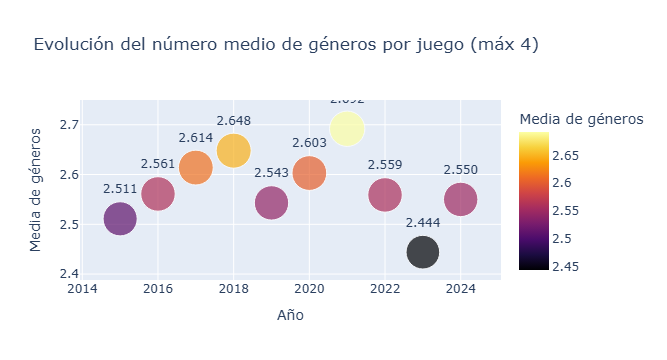

In [116]:
# Filtrar juegos con hasta 4 géneros
df = df[df['n_generos'] <= 4]

# Agrupar y calcular media
generos_por_año = df.groupby('año')['n_generos'].mean().round(3).reset_index()

# Visualización con burbujas
fig1 = px.scatter(
    generos_por_año,
    x='año',
    y='n_generos',
    size='n_generos',
    color='n_generos',
    title='Evolución del número medio de géneros por juego (máx 4)',
    labels={'n_generos': 'Media de géneros', 'año': 'Año'},
    hover_name='año',
    size_max=25,
    color_continuous_scale='inferno',
    text='n_generos'
)
fig1.update_traces(texttemplate='%{text:.3f}', textposition='top center')
fig1.show()


###  8. Extraer género principal
Se toma el primer género del listado como referencia para análisis por categoría principal.

In [108]:
df['genero_principal'] = df['genres'].apply(
    lambda lista: lista[0]['slug'] if isinstance(lista, list) and len(lista) > 0 and 'slug' in lista[0] else 'sin_datos'
)

###  9. Crear tabla pivot para el heatmap
Se calcula la media de puntuación por género principal y año. Luego se transforma en una tabla para visualización, eliminando filas totalmente vacías.

In [111]:
pivot_df = df.groupby(['genero_principal', 'año'])['rating'].mean().reset_index()
heatmap_data = pivot_df.pivot(index='genero_principal', columns='año', values='rating')
heatmap_data = heatmap_data.dropna(how='all')

###  10. Visualización 2 – Heatmap
Se genera un mapa de calor con puntuaciones medias por género y año. Las celdas vacías no se rellenan con ceros, lo que mejora la claridad de la visualización.

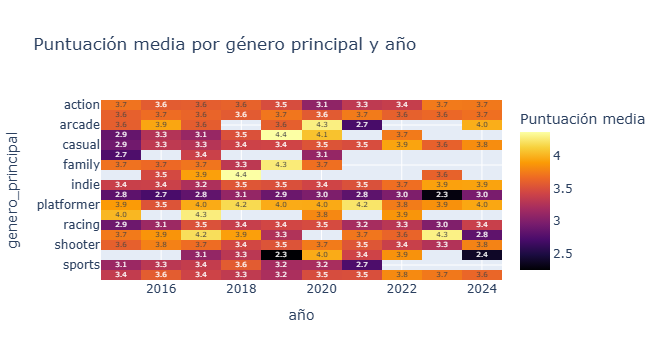

In [114]:
fig2 = px.imshow(
    heatmap_data,
    text_auto='.1f',
    color_continuous_scale='inferno',
    labels={'color': 'Puntuación media'},
    title=' Puntuación media por género principal y año'
)
fig2.show()

## Conclusiones

- El número medio de géneros por juego ha mostrado una evolución que puede reflejar una **tendencia hacia la hibridación**, con títulos cada vez más variados.
- El heatmap revela qué **géneros han mantenido una alta calidad crítica** y cuáles han sufrido una caída en valoración.
- Este tipo de análisis permite observar tanto **tendencias creativas** como **preferencias del mercado** a lo largo del tiempo.
- Las visualizaciones interactivas ofrecen una forma poderosa y clara de comunicar hallazgos a partir de grandes volúmenes de datos del mundo del videojuego.

Este notebook es una base sólida para explorar nuevas dimensiones, como la relación entre plataformas, popularidad (`added`) y valoración.